Overview
--------

Extracting building footprints from LiDAR derived elevation models, NAIP, and thematic mask layers.


Notes
-----

This ruleset relies heavily on the elevation data and does not account for atmospheric conditions, offset between datasets, or the spectral properties of regional vegetation or rooftops.  The segmentation of the elevation data could probably be much better if it considered planarity or incorporated edge detection rather than just a simple threshold.  Additional contextual information like distance from a road could be incorporated depending on the end use.  LiDAR intensity could also be incorporated to better differentiate between rooftops and vegetation.  A final squaring routine would be benificial as well.


Input Data
----------

The thematic data include a subset of roads, hydroline, and hydropoly datasets for Jefferson county WV and Washington county MD.

The input LAZ file in sample data is in UTM zone 18 N.  The derivatative DSM, DTM, and DEM were created with the commands outlined below the `lidar-processing` utility should handle point filtering but currently lacks that functionality.  `las2las` was obtained from a homebrewed install of libLAS.  The input LiDAR data has already been de-noised.

Surface models generated from LiDAR have different names depending on who you ask so for the sake of this exercis they are defined as follows:

1. Digital Surface Model (DSM) - Gridded first return
2. Digital Terrain Model (DTM) - Gridded last return
3. Digital Elevation Model (DEM) - Gridded ground returns/classification

A Normalized Digital Terrain Model is DTM - DEM, which leaves roughly absolute height above ground for the remaining pixels and eliminates most vegetation.  It is immediately clipped to > 3m in order to eliminate ground pixel noise and any building we really care about is at least 3 meters tall.
    
    # DTM
    las2las --last-return-only \
        -i sample-data/VA-WV-MD_FEMA_Region3_UTM18_2012_000842.laz \
        -o sample-data/last.las
    ./lidar-processing.py \
        sample-data/last.las \
        sample-data/DTM.tif \
        -tr 1 1 \
        -co COMPRESS=DEFLATE -co TILED=YES -co PREDICTOR=3 -co ZLEVEL=9 \
        -crs EPSG:32618 \
        --interpolation nearest

    # DEM
    las2las --keep-classes 2 \
        -i sample-data/VA-WV-MD_FEMA_Region3_UTM18_2012_000842.laz \
        -o sample-data/ground.las
    ./lidar-processing.py \
        sample-data/ground.las \
        sample-data/DEM.tif \
        -tr 1 1 \
        -co COMPRESS=DEFLATE -co TILED=YES -co PREDICTOR=3 -co ZLEVEL=9 \
        -crs EPSG:32618 \
        --interpolation nearest
        
    # DSM - not needed for this exercise
    las2las --first-return-only \
        -i sample-data/VA-WV-MD_FEMA_Region3_UTM18_2012_000842.laz \
        -o sample-data/first.las
    ./lidar-processing.py \
        sample-data/first.las \
        sample-data/DSM.tif \
        -tr 1 1 \
        -co COMPRESS=DEFLATE -co TILED=YES -co PREDICTOR=3 -co ZLEVEL=9 \
        -crs EPSG:32618 \
        --interpolation nearest
        

###Imports

In [27]:
%matplotlib inline

from __future__ import division

import os
import fiona
from matplotlib import pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from shapely.geometry import asShape
from scipy import ndimage
from skimage.morphology import opening
from skimage.morphology import watershed

###Identify all the needed files, make sure they exist

Cache the DTM raster's metadata so we can extract information from it later.

In [28]:
dtm_path = 'sample-data/DTM.tif'
dem_path = 'sample-data/DEM.tif'
mask_path = 'sample-data/thematic-mask.tif'
naip_path = 'sample-data/NAIP.tif'

# Keys are paths and vals are buffer distances
thematic_mask_paths = {
    'sample-data/tl_2014_24043_areawater.geojson': 0,
    'sample-data/tl_2014_24_prisecroads.geojson': 3,
    'sample-data/tl_2014_54037_areawater.geojson': 0,
    'sample-data/tl_2014_54037_linearwater.geojson': 1,
    'sample-data/tl_2014_54037_roads.geojson': 3
}

# Define some additional commonly used variables
with rasterio.open(dtm_path) as src:
    dtm_meta = src.meta.copy()
    dtm_shape = src.shape
    dtm_nodata = src.meta['nodata']
    dtm_dtype = src.meta['dtype']
    dtm_affine = src.meta['affine']
    dtm_bounds = src.bounds
    dtm_x_min, dtm_y_min, dtm_x_max, dtm_y_max = dtm_bounds

###Create a mask layer from the thematic datasets

A mask layer would be created here on the fly but I kept encountering issues with
driver clashes between fiona and rasterio and a crashing python kernel.  Instead the mask was built a mask like this:

```
# Buffer the necessary datasources
$ fio cat sample-data/tl_2014_24_prisecroads.geojson \
    | ./streaming-topology-operations.py -to buffer:distance=4 \
    | fio load sample-data/buffered/tl_2014_24_prisecroads.geojson \
        -f GeoJSON --sequence --src_crs EPSG:32618 --dst_crs EPSG:32618
$ fio cat sample-data/tl_2014_54037_linearwater.geojson \
    | ./streaming-topology-operations.py -to buffer:distance=1 \
    | fio load sample-data/buffered/tl_2014_54037_linearwater.geojson \
        -f GeoJSON --sequence --src_crs EPSG:32618 --dst_crs EPSG:32618
$ fio cat sample-data/tl_2014_54037_roads.geojson \
    | ./streaming-topology-operations.py -to buffer:distance=3 \
    | fio load sample-data/buffered/tl_2014_54037_roads.geojson \
        -f GeoJSON --sequence --src_crs EPSG:32618 --dst_crs EPSG:32618

# Get an empty version of the DSM to use as a field for rasterization
$ gdal_calc.py -A sample-data/DTM.tif \
    --calc="0" \
    --out=sample-data/thematic-mask.tif \
    --co=COMPRESS=LZW --co=ZLEVEL=9 \
    --co=TILED=YES --co=NBITS=1 --type=Byte 

$ gdal_rasterize -burn 1 \
    sample-data/tl_2014_24043_areawater.geojson \
    sample-data/thematic-mask.tif 
$ gdal_rasterize -burn 1 \
    sample-data/tl_2014_54037_areawater.geojson \
    sample-data/thematic-mask.tif 
$ gdal_rasterize -burn 1 \
    sample-data/buffered/tl_2014_24_prisecroads.geojson \
    sample-data/thematic-mask.tif 
$ gdal_rasterize -burn 1 \
    sample-data/buffered/tl_2014_54037_linearwater.geojson \
    sample-data/thematic-mask.tif 
$ gdal_rasterize -burn 1 \
    sample-data/buffered/tl_2014_54037_roads.geojson \
    sample-data/thematic-mask.tif
```


Attempted mask building:

```
mask_layer = np.full(dtm_shape, 0, dtm_dtype)
for mask_path, buff_dist in thematic_mask_paths.items():
    with fiona.open(mask_path) as src:
        mask_layer = rasterize(
            shapes=[asShape(f['geometry']).buffer(buff_dist) for f in src],
            out_shape=mask_layer.shape,
            fill=1,
            out=mask_layer,
            transform=dtm_affine,
            all_touched=True,
            default_value=0,
            dtype='uint8'
        )
```

In [29]:
# Generate a Normalized DTM by subtracting the DEM from the DTM to give
# us absolute height above ground while removing all but the
# most dense vegetation
with rasterio.open(dtm_path) as dtm, rasterio.open(dem_path) as dem:
    ndtm = dtm.read_band(1) - dem.read_band(1)

In [30]:
# Load the intersecting NAIP area
with rasterio.open(naip_path) as src:
    col_min, row_min = [int(v) for v in ~src.affine * (dtm_x_min, dtm_y_max)]
    col_max, row_max = [int(v) for v in ~src.affine * (dtm_x_max, dtm_y_min)]
    window = ((row_min, row_max), (col_min, col_max))
    naip = src.read(
        window=window,
        out=np.empty([src.count] + list(dtm_shape), dtype=src.meta['dtype']),
        boundless=True
    )

###Display layers

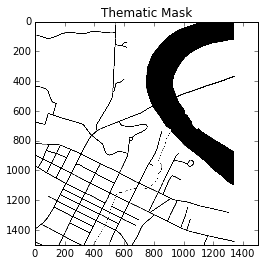

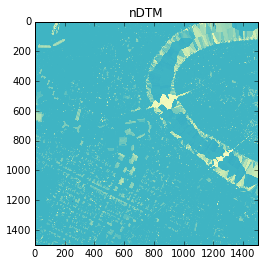

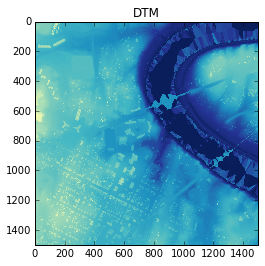

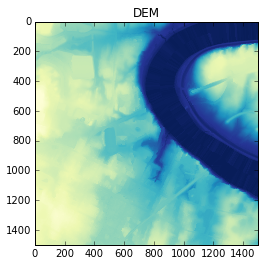

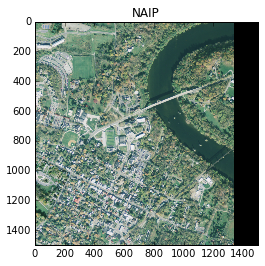

In [31]:
with rasterio.open(mask_path) as src:
    thematic_mask = src.read_band(1).astype(np.bool_)

plt.title("Thematic Mask")
plt.imshow(thematic_mask)
plt.set_cmap('binary')
plt.show()

plt.title("nDTM")
plt.imshow(ndtm)
plt.set_cmap('YlGnBu_r')
plt.show()

with rasterio.open(dtm_path) as dtm:
    plt.title("DTM")
    plt.imshow(dtm.read_band(1))
    plt.show()

with rasterio.open(dem_path) as dem:
    plt.title("DEM")
    plt.imshow(dem.read_band(1))
    plt.show()

plt.title("NAIP")
plt.imshow(np.transpose(naip, [1,2,0]))
plt.show()

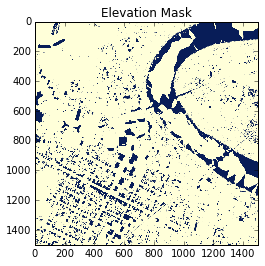

In [32]:
# Buildings we're interested in are at least 2.5 meters tall.  Mask everything else.
markers = np.zeros_like(ndtm)
markers[ndtm < 2.5] = 1
markers[ndtm >= 2.5] = 2

# Immediately subtract 1 to match other masks
elevation_mask = ~(watershed(ndtm, markers) - 1).astype(np.bool_)
plt.title("Elevation Mask")
plt.imshow(elevation_mask)
plt.show()

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


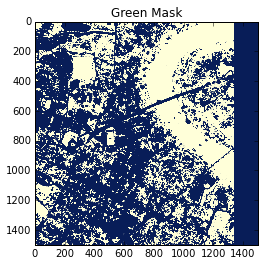

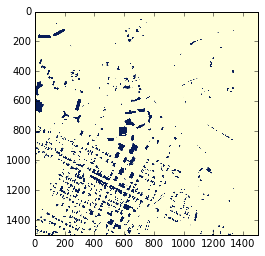

In [33]:
# The NAIP we're working with doesn't have NIR, which would be
# extremely useful for eliminating vegetation, so we have to compute
# a greenness index to use for the same purpose.
# g / sum(r, g, b)
green_mask = naip[1] / (
    naip[0].astype(np.float32) + 
    naip[1].astype(np.float32) + 
    naip[2].astype(np.float32)
)
green_mask = np.nan_to_num(green_mask)
green_mask = green_mask >= 0.38
plt.title("Green Mask")
plt.imshow(green_mask)
plt.show()

# Merge elevation, thematic, and green masks together and add black
# NAIP pixels and fill small non-masked areas.  The buildings we care
# about are at least 25 square meters.
merged_mask = ((naip[0] == 0) & (naip[1] == 0) & (naip[2] == 0)) \
    + thematic_mask + elevation_mask + green_mask
m_segments, m_segment_labels = ndimage.label(~merged_mask)
m_segment_sizes = np.bincount(m_segments.ravel()) > 25
m_segment_sizes[0] = 0
final_mask = ~(m_segment_sizes[m_segments])

# Quick morphological cleanup
final_mask = opening(final_mask.astype(np.bool_)).astype(np.bool_)
plt.imshow(final_mask)
plt.show()

meta = dtm_meta.copy()
meta['dtype'] = np.uint8
with rasterio.open('BAH.tif', 'w', **meta) as dst:
    dst.write_band(1, final_mask.astype(np.uint8))

In [34]:
# Normally this would be where the output data would be vectorized
# and additional morphological and topological operations would be performed
# but Fiona is not coperating so the final output is written back to a raster.
processed = []
for idx, (geom, dn) in enumerate(
    rasterio.features.shapes(final_mask.astype(np.uint8), transform=dtm_affine)):
    if dn == 0:
        geom = asShape(geom)
        geom = geom.simplify(3)
#         geom = geom.buffer(1)  # Geometry is causing a segfault
#         geom = geom.buffer(-1)
        processed.append(geom)
rasterized = rasterize(
    shapes=processed,
    out_shape=ndtm.shape,
    transform=dtm_affine,
)
meta = dtm_meta.copy()
meta.update({
        'COMPRESS': 'LZW',
        'TILED': 'YES',
        'dtype': np.uint8,
        'nodata': None,
        'count': 1,
    })
with rasterio.open('Extracted-Buildings.tif', 'w', **meta) as dst:
    dst.write_band(1, rasterized.astype(dst.meta['dtype']))